# ARIMA MODEL TRAINING
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helpers import (
    find_best_sarima_cached,
    find_missing_date_ranges,
    present_base_dataset,
    evaluate_predictions,
    compare_prediction,
)
from enums import (
    DatasetColumns,
    WeatherDatasetColumns
)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

## Data Preparation
---


In [2]:
#  Constants
FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"

In [3]:
# Load data
original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

In [4]:
# Find missing date ranges
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)
gap_dates = pd.date_range(start=gap_start, end=gap_end, freq="h")

In [5]:
# Split data and Handling Null
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[
    :pre_gap_train_size
].copy() 
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]


post_gap_data = original_data[original_data.index >= gap_end].asfreq("h")

pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
gap_weather_data = weather_data.reindex(gap_dates).ffill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()

pre_gap_train.loc[:, DatasetColumns.PV_YIELD.value] = pre_gap_train[
    DatasetColumns.PV_YIELD.value
].interpolate(method="linear")

pre_weather_data = pre_weather_data.drop(
    pre_weather_data.index.difference(pre_gap_data.index)
)

## `pre_gap_data` training model
---

In [6]:
# Tune hyperparameters
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
seasonal_period = 24 

best_params, best_aic = find_best_sarima_cached(
    pre_gap_train[DatasetColumns.PV_YIELD.value],
    seasonal_period,
    p,
    d,
    q,
    P,
    D,
    Q,
)

(order_params, seasonal_params) = best_params
print(f"Best Parameters: {best_params}, AIC: {best_aic}")

Best Parameters: ((2, 0, 0), (1, 1, 1)), AIC: -4804.99589339206


In [ ]:
# Train without exocgenous variables and seasonal components
def train_arima_model():
    arima_model = ARIMA(
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        order=order_params,  
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    arima_result = arima_model.fit()
    preds = arima_result.predict(start=pre_gap_test.index[0], end=pre_gap_test.index[-1])

    evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], preds)    
    
    compare_prediction(
        "ARIMA Predictions vs Actual",
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        pre_gap_test[DatasetColumns.PV_YIELD.value],
        preds,
    )
    
train_arima_model()

In [ ]:
# Train without exocgenous variables
def train_sarima_model():
    sarimax_model = SARIMAX(
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result = sarimax_model.fit()
    preds = sarimax_result.predict(
        start=pre_gap_test.index[0], end=pre_gap_test.index[-1]
    )

    evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], preds)

    compare_prediction(
        "SARIMA without Exogenous Predictions vs Actual",
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        pre_gap_test[DatasetColumns.PV_YIELD.value],
        preds,
    )


train_sarima_model()

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.42872D-01    |proj g|=  1.36185D+00


 This problem is unconstrained.



At iterate    5    f= -5.61953D-01    |proj g|=  6.38594D-01

At iterate   10    f= -5.84555D-01    |proj g|=  3.59259D-01

At iterate   15    f= -6.12240D-01    |proj g|=  2.12397D+00

At iterate   20    f= -6.22863D-01    |proj g|=  1.48155D-01

At iterate   25    f= -6.33609D-01    |proj g|=  1.47442D-01

At iterate   30    f= -6.34013D-01    |proj g|=  3.16261D-01

At iterate   35    f= -6.34468D-01    |proj g|=  1.48263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     55      1     0     0   1.091D-03  -6.345D-01
  F = -0.63446822443305773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

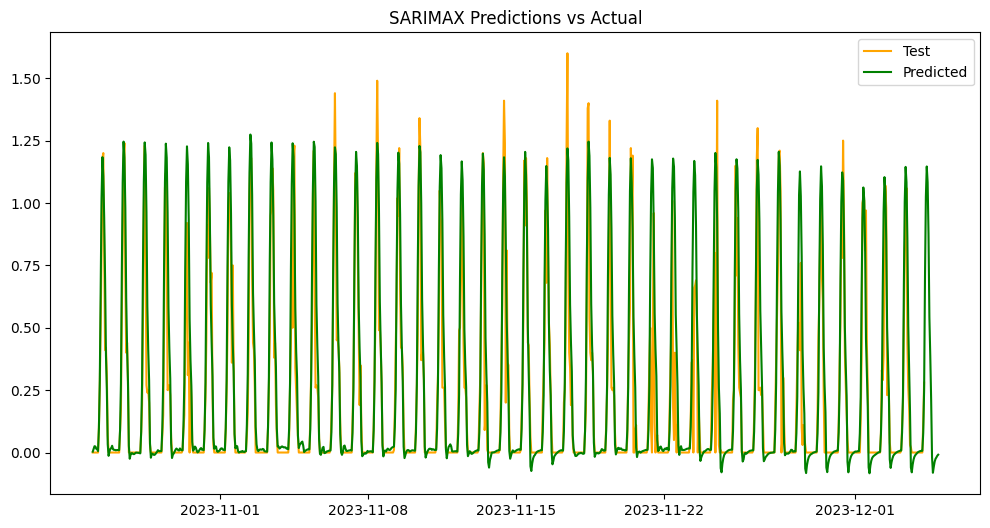

In [ ]:
# Train with Exogenous Variables
def train_sarima_with_exogenous():
    merged_train = pre_gap_train.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )
    merged_test = pre_gap_test.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )

    exog_train = merged_train[weather_features].ffill()
    exog_test = merged_test[weather_features].ffill()

    sarimax_model_exog = SARIMAX(
        merged_train[DatasetColumns.PV_YIELD.value],
        exog=exog_train,
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result_exog = sarimax_model_exog.fit()

    preds_exog = sarimax_result_exog.predict(
        start=merged_test.index[0],
        end=merged_test.index[-1],
        exog=exog_test,
    )

    evaluate_predictions(merged_test[DatasetColumns.PV_YIELD.value], preds_exog)

    compare_prediction(
        "SARIMAX Predictions vs Actual",
        test_data=merged_test[DatasetColumns.PV_YIELD.value],
        predicted=preds_exog,
    )
    return sarimax_result_exog


# Train the model and retrieve the results
trained_model = train_sarima_with_exogenous()
trained_model.save("sarimax_model_results.pkl")

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.62364D-01    |proj g|=  1.10517D+00

At iterate    5    f= -4.83567D-01    |proj g|=  6.23166D-01

At iterate   10    f= -4.93792D-01    |proj g|=  3.34937D-01

At iterate   15    f= -4.95928D-01    |proj g|=  2.59586D-01

At iterate   20    f= -4.98344D-01    |proj g|=  3.30997D-01

At iterate   25    f= -5.00457D-01    |proj g|=  1.05682D-01

At iterate   30    f= -5.07073D-01    |proj g|=  8.85330D-01

At iterate   35    f= -5.14028D-01    |proj g|=  1.69552D-01

At iterate   40    f= -5.16565D-01    |proj g|=  1.49147D-02

At iterate   45    f= -5.16576D-01    |proj g|=  1.26651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.06825D-01    |proj g|=  1.24586D+00

At iterate    5    f= -5.22309D-01    |proj g|=  3.76711D-01

At iterate   10    f= -5.32437D-01    |proj g|=  1.73286D-01

At iterate   15    f= -5.36709D-01    |proj g|=  4.10538D-01

At iterate   20    f= -5.47786D-01    |proj g|=  5.67596D-01

At iterate   25    f= -5.60080D-01    |proj g|=  1.68333D-01

At iterate   30    f= -5.67147D-01    |proj g|=  1.36712D-01

At iterate   35    f= -5.69183D-01    |proj g|=  6.72141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.03499D-01    |proj g|=  1.10522D+00


 This problem is unconstrained.



At iterate    5    f= -5.13357D-01    |proj g|=  4.38639D-01

At iterate   10    f= -5.24825D-01    |proj g|=  3.83116D-01

At iterate   15    f= -5.27468D-01    |proj g|=  5.94501D-01

At iterate   20    f= -5.53643D-01    |proj g|=  1.34309D-01

At iterate   25    f= -5.68312D-01    |proj g|=  4.65261D-01

At iterate   30    f= -5.71225D-01    |proj g|=  1.00492D-01

At iterate   35    f= -5.74481D-01    |proj g|=  2.83250D-02

At iterate   40    f= -5.74553D-01    |proj g|=  1.44895D-02

At iterate   45    f= -5.74554D-01    |proj g|=  4.07551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     51   

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95834D-01    |proj g|=  1.19787D+00

At iterate    5    f= -5.10727D-01    |proj g|=  9.75814D-01

At iterate   10    f= -5.26906D-01    |proj g|=  6.60473D-01

At iterate   15    f= -5.48363D-01    |proj g|=  7.41085D-01

At iterate   20    f= -5.69533D-01    |proj g|=  2.88696D-01

At iterate   25    f= -5.76244D-01    |proj g|=  4.96737D-02

At iterate   30    f= -5.79374D-01    |proj g|=  7.37185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/richie/miniforge3/envs/solar-prediction/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15851D-01    |proj g|=  1.27129D+00


 This problem is unconstrained.



At iterate    5    f= -5.29228D-01    |proj g|=  4.01831D-01

At iterate   10    f= -5.45886D-01    |proj g|=  7.99449D-01

At iterate   15    f= -5.54462D-01    |proj g|=  1.20665D+00

At iterate   20    f= -5.83756D-01    |proj g|=  1.34779D+00

At iterate   25    f= -5.93650D-01    |proj g|=  4.58854D-01

At iterate   30    f= -6.04440D-01    |proj g|=  4.90409D-02

At iterate   35    f= -6.05796D-01    |proj g|=  5.21276D-02

At iterate   40    f= -6.05872D-01    |proj g|=  7.33831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     51      1     0     0   5.191D-04  -6.059D-01
  F = -0.605872186218

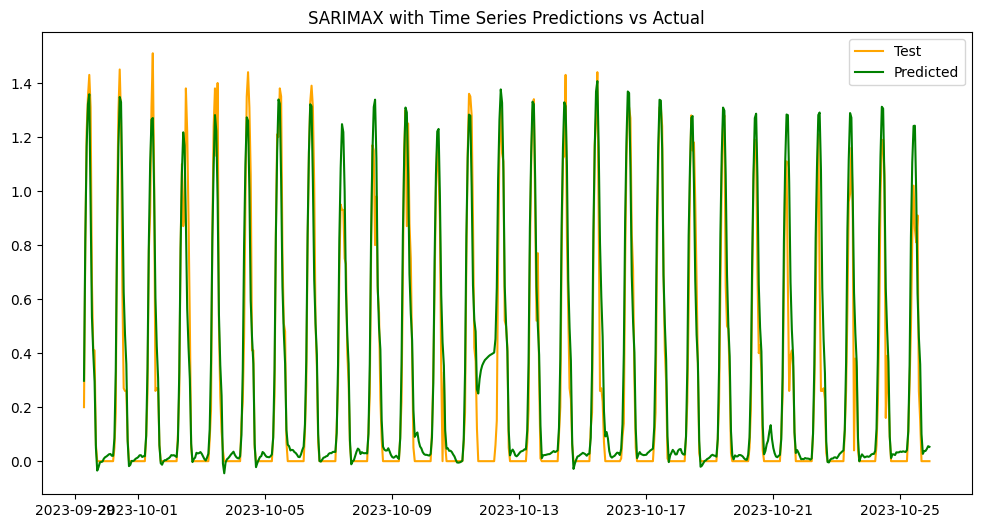

In [8]:
# Train with Exogenous Variables using Time-Series Cross-Validation
def train_sarima_with_exogenous_cv():
    merged_data = pre_gap_train.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )
    
    exog_data = merged_data[weather_features]
    ts_cv = TimeSeriesSplit(n_splits=5) 
    
    model = None

    for i, (train_idx, test_idx) in enumerate(ts_cv.split(merged_data)):
        train_data, test_data = merged_data.iloc[train_idx], merged_data.iloc[test_idx]
        exog_train, exog_test = exog_data.iloc[train_idx], exog_data.iloc[test_idx]

        sarimax_model_exog = SARIMAX(
            train_data[DatasetColumns.PV_YIELD.value],
            exog=exog_train,
            order=order_params,
            seasonal_order=seasonal_params + (seasonal_period,),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        sarimax_result_exog = sarimax_model_exog.fit()

        preds_exog = sarimax_result_exog.predict(
            start=test_data.index[0],
            end=test_data.index[-1],
            exog=exog_test,
        )

        if i == ts_cv.n_splits - 1:
            evaluate_predictions(test_data[DatasetColumns.PV_YIELD.value], preds_exog)
            compare_prediction(
                f"SARIMAX with Time Series Predictions vs Actual",
                test_data=test_data[DatasetColumns.PV_YIELD.value],
                predicted=preds_exog,
            )

            model = sarimax_result_exog

    return model

trained_model_cv = train_sarima_with_exogenous_cv()
trained_model_cv.save("sarimax_cv_model_results.pkl")

In [ ]:
# Combine Gap Prediction
exog_gap = gap_weather_data[weather_features]
gap_predictions = trained_model_cv.forecast(steps=len(gap_dates), exog=exog_gap)
gap_predictions = gap_predictions.clip(lower=0)
gap_predictions_df = gap_predictions.to_frame(name=DatasetColumns.PV_YIELD.value)
gap_predictions_df.index = gap_dates

combined_data = pd.concat([pre_gap_data, gap_predictions_df, post_gap_data]).asfreq("h")
combined_data.to_csv("combined_data.csv", index=True)
combined_data_train_size = int(len(combined_data) * 0.8)
combined_data_train = combined_data.iloc[:combined_data_train_size].copy()
combined_data_test = combined_data.iloc[combined_data_train_size:]